In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
pd.set_option('display.max_columns', None)

In [23]:
ridership = pd.read_csv('data/ridership_detail.csv')
ridership['transit_timestamp'] = pd.to_datetime(ridership['transit_timestamp'])

ridership.head()

/var/folders/1w/nb8zzzyd2b19zfmmnsf651j00000gn/T/ipykernel_86909/60106925.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  ridership = pd.read_csv('data/ridership_detail.csv')


,transit_timestamp,station_complex_id,station_complex,borough,routes,payment_method,ridership,transfers,latitude,longitude,Georeference,itsuid,date,year,month,day,weekday,week,quarter,hour,year-month,year-week
0,2022-08-04 04:00:00,H007,1 Av (L),M,L,omny,11,0,40.730953,-73.981628,POINT (-73.98162841796875 40.730953216552734),2022-08-04T04:00:00H0071 Av (L)MLomny,2022-08-04,2022,8,4,3,31,3,4,2022-08,2022-08-01/2022-08-07
1,2023-02-13 03:00:00,H007,1 Av (L),M,L,omny,10,0,40.730953,-73.981628,POINT (-73.98162841796875 40.730953216552734),2023-02-13T03:00:00H0071 Av (L)MLomny,2023-02-13,2023,2,13,0,7,1,3,2023-02,2023-02-13/2023-02-19
2,2023-03-08 04:00:00,H007,1 Av (L),M,L,omny,4,0,40.730953,-73.981628,POINT (-73.98162841796875 40.730953216552734),2023-03-08T04:00:00H0071 Av (L)MLomny,2023-03-08,2023,3,8,2,10,1,4,2023-03,2023-03-06/2023-03-12
3,2023-03-23 03:00:00,H007,1 Av (L),M,L,omny,10,0,40.730953,-73.981628,POINT (-73.98162841796875 40.730953216552734),2023-03-23T03:00:00H0071 Av (L)MLomny,2023-03-23,2023,3,23,3,12,1,3,2023-03,2023-03-20/2023-03-26
4,2023-04-03 05:00:00,H007,1 Av (L),M,L,omny,28,0,40.730953,-73.981628,POINT (-73.98162841796875 40.730953216552734),2023-04-03T05:00:00H0071 Av (L)MLomny,2023-04-03,2023,4,3,0,14,2,5,2023-04,2023-04-03/2023-04-09


In [24]:
np.mean(ridership['ridership'])

237.82406003788708

In [25]:
# row with max ridership
ridership[ridership['ridership'] == max(ridership['ridership'])]

,transit_timestamp,station_complex_id,station_complex,borough,routes,payment_method,ridership,transfers,latitude,longitude,Georeference,itsuid,date,year,month,day,weekday,week,quarter,hour,year-month,year-week
11050241,2023-09-20 17:00:00,N060,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,...",M,"3,C,1,2,S,7,F,M,E,N,R,Q,,B,W,A,D",omny,55796,188,40.757309,-73.981964,POINT (-73.98196411132812 40.75730895996094),"2023-09-20T17:00:00N060Times Sq-42 St (N,Q,R,W...",2023-09-20,2023,9,20,2,38,3,17,2023-09,2023-09-18/2023-09-24


In [63]:
ridership_total = ridership.groupby(['transit_timestamp', 'station_complex_id'])['ridership'].sum().reset_index()
ridership_total.head()

,transit_timestamp,station_complex_id,ridership
0,2022-02-01,A002,376
1,2022-02-01,A006,98
2,2022-02-01,A010,232
3,2022-02-01,A013,200
4,2022-02-01,A022,772


In [267]:
ridership_total['ridership'].max()

98312

In [64]:
ridership_total['year'] = ridership_total['transit_timestamp'].dt.year
ridership_total['month'] = ridership_total['transit_timestamp'].dt.month
ridership_total['day'] = ridership_total['transit_timestamp'].dt.day
ridership_total['hour'] = ridership_total['transit_timestamp'].dt.hour
ridership_total['weekday'] = ridership_total['transit_timestamp'].dt.weekday
ridership_total['weekend'] = ridership_total['weekday'].apply(lambda x: 1 if x >= 5 else 0)

ridership_total.head()

,transit_timestamp,station_complex_id,ridership,year,month,day,hour,weekday,weekend
0,2022-02-01,A002,376,2022,2,1,0,1,0
1,2022-02-01,A006,98,2022,2,1,0,1,0
2,2022-02-01,A010,232,2022,2,1,0,1,0
3,2022-02-01,A013,200,2022,2,1,0,1,0
4,2022-02-01,A022,772,2022,2,1,0,1,0


(0.0, 1000.0)

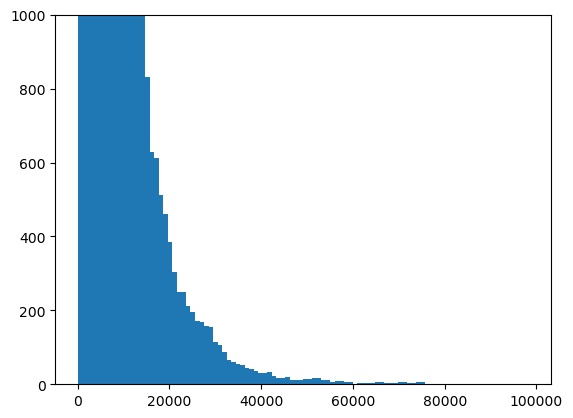

In [66]:
plt.hist(ridership_total['ridership'], bins=100)
plt.ylim(0, 1000)

In [67]:
# First idea: simple random forest regressor based on year, month, day, hour, and station
# ['year', 'month', 'day', 'weekday', 'hour', '7 day avg hour ridership', '1 day avg hour ridership', 'last hour ridership', 'ridership']

# get 10,000 random rows
ridership_after_20220301 = ridership_total[ridership_total['transit_timestamp'] > pd.Timestamp(2022, 3, 1)]
ridership_sample = ridership_after_20220301.sample(n=1000, random_state=1)
ridership_sample.head()

,transit_timestamp,station_complex_id,ridership,year,month,day,hour,weekday,weekend
1629949,2022-07-14 10:00:00,R513,439,2022,7,14,10,3,0
2749879,2022-11-03 05:00:00,N557,94,2022,11,3,5,3,0
5039178,2023-06-20 03:00:00,R160,9,2023,6,20,3,1,0
2256464,2022-09-14 20:00:00,N185,6,2022,9,14,20,2,0
5235318,2023-07-09 19:00:00,R309,78,2023,7,9,19,6,1


In [103]:
def seven_day_avg_hour_ridership(station_complex_id, time_stamp, df):
    """
    Returns the average ridership for the 7 days prior to the given time_stamp
    """
    try:
        time_stamp = pd.to_datetime(time_stamp)
        df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])
        seven_days = pd.Timedelta(days=7)
        seven_days_prior = time_stamp - seven_days
        seven_days_prior = seven_days_prior.replace(hour=time_stamp.hour)
        df_station = df[df['station_complex_id'] == station_complex_id]
        df_station_7days = df_station[(df_station['transit_timestamp'] >= seven_days_prior) & (df_station['transit_timestamp'] < time_stamp)]
    except:
        return np.nan
    return np.mean(df_station_7days['ridership'])

def one_day_avg_hour_ridership(station_complex_id, time_stamp, df):
    """
    Returns the average ridership for the 1 day prior to the given time_stamp
    """
    try:
        time_stamp = pd.to_datetime(time_stamp)
        df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])
        one_day = pd.Timedelta(days=1)
        one_day_prior = time_stamp - one_day
        one_day_prior = one_day_prior.replace(hour=time_stamp.hour)
        df_station = df[df['station_complex_id'] == station_complex_id]
        df_station_1day = df_station[(df_station['transit_timestamp'] >= one_day_prior) & (df_station['transit_timestamp'] < time_stamp)]
    except:
        return np.nan
    return np.mean(df_station_1day['ridership'])

def last_hour_ridership(station_complex_id, time_stamp, df):
    try:
        time_stamp = pd.to_datetime(time_stamp)
        df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])
        one_hour = pd.Timedelta(hours=1)
        one_hour_prior = time_stamp - one_hour
        df_station = df[df['station_complex_id'] == station_complex_id]
        df_station_1hour = df_station[(df_station['transit_timestamp'] == one_hour_prior)]
        return df_station_1hour['ridership'].values[0]
    except:
        return np.nan

In [104]:
test_timestamp = ridership_sample.iloc[999, :]['transit_timestamp']
test_station_id = ridership_sample.iloc[999, :]['station_complex_id']
print(test_timestamp)
print(test_station_id)

2023-03-04 10:00:00
N343


In [105]:
seven_day_avg_hour_ridership(test_station_id, test_timestamp, ridership_total)

470.54761904761904

In [106]:
one_day_avg_hour_ridership(test_station_id, test_timestamp, ridership_total)

301.75

In [107]:
last_hour_ridership(test_station_id, test_timestamp, ridership_total)

465

In [110]:
ridership_sample_100 = ridership_sample.sample(n=100, random_state=1)
ridership_sample_100.shape

(100, 9)

In [111]:
ridership_sample_100['last_hour'] = ridership_sample_100.apply(lambda row: last_hour_ridership(row['station_complex_id'], row['transit_timestamp'], ridership_total), axis=1)

In [112]:
ridership_sample_100.isnull().sum()

transit_timestamp     0
station_complex_id    0
ridership             0
year                  0
month                 0
day                   0
hour                  0
weekday               0
weekend               0
last_hour             1
dtype: int64

In [115]:
# check rows with null values
na_test = ridership_sample_100[ridership_sample_100['last_hour'].isnull()]
na_test

,transit_timestamp,station_complex_id,ridership,year,month,day,hour,weekday,weekend,last_hour
3892794,2023-02-25 02:00:00,H022,6,2023,2,25,2,5,1,NaN


In [116]:
na_test_onehour = na_test.apply(lambda row: last_hour_ridership(row['station_complex_id'], row['transit_timestamp'], ridership_total), axis=1)


3892794   NaN
dtype: float64

In [118]:
row = na_test.iloc[0, :]
print(row['station_complex_id'])
print(row['transit_timestamp'])

H022
2023-02-25 02:00:00


In [122]:
last_hour_ridership('H022', pd.Timestamp(2023, 2, 25, 2), ridership_total)

nan

In [126]:
test_station = ridership_total[ridership_total['station_complex_id'] == 'H022']
test_station[test_station['transit_timestamp'] == pd.Timestamp(2023, 2, 25, 0)]

,transit_timestamp,station_complex_id,ridership,year,month,day,hour,weekday,weekend
3892008,2023-02-25,H022,9,2023,2,25,0,5,1


H022 doesn't have 2023-02-25 1:00:00

In [127]:
# data prep for rf
ridership_sample['seven_day_avg'] = ridership_sample.apply(lambda row: seven_day_avg_hour_ridership(row['station_complex_id'], row['transit_timestamp'], ridership), axis=1)
ridership_sample['one_day_avg'] = ridership_sample.apply(lambda row: one_day_avg_hour_ridership(row['station_complex_id'], row['transit_timestamp'], ridership), axis=1)
ridership_sample['last_hour'] = ridership_sample.apply(lambda row: last_hour_ridership(row['station_complex_id'], row['transit_timestamp'], ridership), axis=1)
ridership_sample.head()

,transit_timestamp,station_complex_id,ridership,year,month,day,hour,weekday,weekend,seven_day_avg,one_day_avg,last_hour
1629949,2022-07-14 10:00:00,R513,439,2022,7,14,10,3,0,150.265672,173.208333,460.0
2749879,2022-11-03 05:00:00,N557,94,2022,11,3,5,3,0,53.328125,59.369565,5.0
5039178,2023-06-20 03:00:00,R160,9,2023,6,20,3,1,0,763.210843,563.617021,6.0
2256464,2022-09-14 20:00:00,N185,6,2022,9,14,20,2,0,7.572954,8.743590,1.0
5235318,2023-07-09 19:00:00,R309,78,2023,7,9,19,6,1,103.559633,72.255319,66.0


In [128]:
ridership_sample.to_csv('data/ridership_sample.csv', index=False)

In [129]:
ridership_sample.isna().sum()

transit_timestamp     0
station_complex_id    0
ridership             0
year                  0
month                 0
day                   0
hour                  0
weekday               0
weekend               0
seven_day_avg         0
one_day_avg           0
last_hour             4
dtype: int64

In [132]:
ridership_sample.dropna(inplace=True)

In [211]:
ridership_df = ridership_sample[['year', 'month', 'day', 'weekday', 'hour', 'last_hour', 'ridership']]

X = ridership_df.iloc[:, :-1]
y = ridership_df.iloc[:, -1]

In [212]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('R2 score: %.2f' % r2_score(y_test, y_pred))

Mean squared error: 318624.75
R2 score: 0.82


Text(0.5, 1.0, 'Feature Importance')

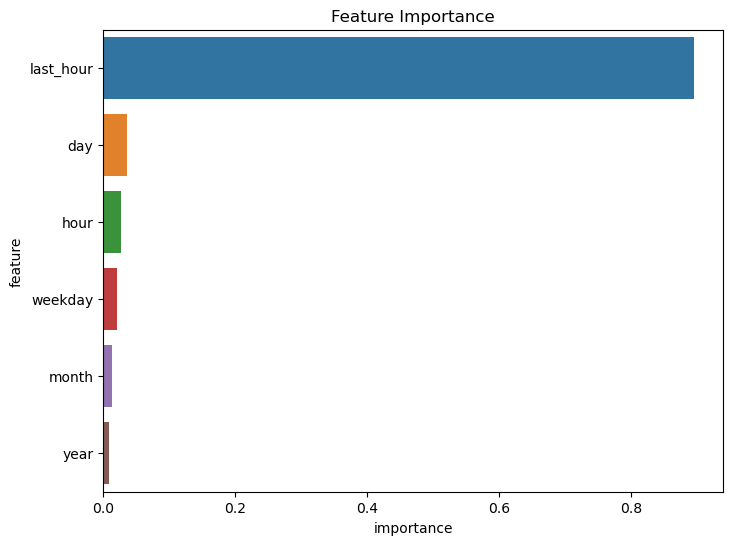

In [264]:
# Plot feature importance

feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importance.sort_values('importance', ascending=False, inplace=True)
plt.figure(figsize=(8, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')

In [214]:
# save random forest model
import pickle

pickle.dump(rf, open('models/rf_model.pkl', 'wb'))

In [147]:
# second idea: 60 day rolling window to predict next day ridership using time series models like ARIMA

def last_72_hour(station_complex_id, time_stamp, df):
    try:
        time_stamp = pd.to_datetime(time_stamp)
        df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])
        three_days = pd.Timedelta(days=3)
        two_days_prior = time_stamp - three_days
        df_station = df[df['station_complex_id'] == station_complex_id]
        df_station_2days = df_station[(df_station['transit_timestamp'] >= two_days_prior) & (df_station['transit_timestamp'] < time_stamp)]
        df_station_2days.sort_values('transit_timestamp', ascending=True, inplace=True)
        return df_station_2days['ridership'].values
    except:
        return np.nan

In [148]:
ridership_sample['last_72hr_ts'] = ridership_sample.apply(lambda row: last_72_hour(row['station_complex_id'], row['transit_timestamp'], ridership_total), axis=1)

ridership_sample.isna().sum()

transit_timestamp     0
station_complex_id    0
ridership             0
year                  0
month                 0
day                   0
hour                  0
weekday               0
weekend               0
seven_day_avg         0
one_day_avg           0
last_hour             0
last_48hr_ts          0
last_72hr_ts          0
dtype: int64

In [149]:
ridership_sample.to_csv('data/ridership_sample.csv', index=False)

In [150]:
ridership_sample.head()

,transit_timestamp,station_complex_id,ridership,year,month,day,hour,weekday,weekend,seven_day_avg,one_day_avg,last_hour,last_48hr_ts,last_72hr_ts
1629949,2022-07-14 10:00:00,R513,439,2022,7,14,10,3,0,150.265672,173.208333,460.0,"[466, 317, 290, 301, 332, 400, 493, 523, 382, ...","[364, 313, 285, 312, 333, 421, 465, 484, 355, ..."
2749879,2022-11-03 05:00:00,N557,94,2022,11,3,5,3,0,53.328125,59.369565,5.0,"[79, 189, 438, 414, 196, 137, 96, 96, 93, 147,...","[83, 190, 393, 392, 198, 109, 71, 103, 98, 171..."
5039178,2023-06-20 03:00:00,R160,9,2023,6,20,3,1,0,763.210843,563.617021,6.0,"[30, 15, 33, 105, 156, 333, 549, 813, 1197, 13...","[24, 30, 66, 243, 243, 462, 747, 1104, 1323, 1..."
2256464,2022-09-14 20:00:00,N185,6,2022,9,14,20,2,0,7.572954,8.743590,1.0,"[3, 6, 1, 1, 2, 1, 1, 3, 11, 22, 23, 58, 19, 1...","[1, 5, 5, 2, 2, 2, 3, 8, 17, 30, 46, 17, 11, 7..."
5235318,2023-07-09 19:00:00,R309,78,2023,7,9,19,6,1,103.559633,72.255319,66.0,"[222, 168, 144, 84, 21, 27, 6, 12, 6, 24, 96, ...","[222, 111, 81, 78, 54, 21, 18, 12, 6, 66, 201,..."


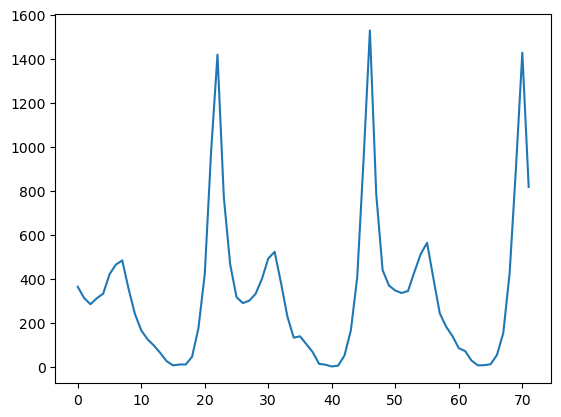

In [160]:
# fit ARIMA model for each data point and calculate MSE and R2
from statsmodels.tsa.arima.model import ARIMA

test_past_72hr = ridership_sample.iloc[0, :]['last_72hr_ts']
test_pred = ridership_sample.iloc[0, :]['ridership']

plt.plot(test_past_72hr)

In [161]:
# fit ARIMA model, find best p, d, q
# p: lag order
# d: degree of differencing
# q: order of moving average

# p = 1, d = 1, q = 1
model = ARIMA(test_past_72hr, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

# p = 1, d = 1, q = 2
model = ARIMA(test_past_72hr, order=(1, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

# p = 1, d = 2, q = 1
model = ARIMA(test_past_72hr, order=(1, 2, 1))
model_fit = model.fit()
print(model_fit.summary())

# p = 1, d = 2, q = 2
model = ARIMA(test_past_72hr, order=(1, 2, 2))
model_fit = model.fit()
print(model_fit.summary())

# p = 2, d = 1, q = 1
model = ARIMA(test_past_72hr, order=(2, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

# p = 2, d = 1, q = 2
model = ARIMA(test_past_72hr, order=(2, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

# p = 2, d = 2, q = 1
model = ARIMA(test_past_72hr, order=(2, 2, 1))
model_fit = model.fit()
print(model_fit.summary())

# p = 2, d = 2, q = 2
model = ARIMA(test_past_72hr, order=(2, 2, 2))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   72
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -481.466
Date:                Sun, 08 Oct 2023   AIC                            968.931
Time:                        00:15:20   BIC                            975.719
Sample:                             0   HQIC                           971.631
                                 - 72                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1565      0.347     -0.451      0.652      -0.837       0.524
ma.L1          0.5626      0.411      1.368      0.171      -0.244       1.369
sigma2      4.532e+04   5640.241      8.035      0.0

/opt/homebrew/Caskroom/miniforge/base/envs/env_base/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   72
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -475.555
Date:                Sun, 08 Oct 2023   AIC                            959.110
Time:                        00:15:20   BIC                            968.104
Sample:                             0   HQIC                           962.683
                                 - 72                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4191      0.125      3.358      0.001       0.174       0.664
ar.L2         -0.3454      0.156     -2.220      0.026      -0.650      -0.040
ma.L1         -1.0000      0.133     -7.535      0.0

/opt/homebrew/Caskroom/miniforge/base/envs/env_base/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/Caskroom/miniforge/base/envs/env_base/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [157]:
def next_24_hour(station_complex_id, time_stamp, df):
    try:
        time_stamp = pd.to_datetime(time_stamp)
        df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])
        one_day = pd.Timedelta(days=1)
        one_day_prior = time_stamp + one_day
        df_station = df[df['station_complex_id'] == station_complex_id]
        df_station_1day = df_station[(df_station['transit_timestamp'] >= time_stamp) & (df_station['transit_timestamp'] < one_day_prior)]
        df_station_1day.sort_values('transit_timestamp', ascending=True, inplace=True)
        return df_station_1day['ridership'].values
    except:
        return np.nan

ridership_sample['next_24hr_ts'] = ridership_sample.apply(lambda row: next_24_hour(row['station_complex_id'], row['transit_timestamp'], ridership_total), axis=1)

test_next_24hr = ridership_sample.iloc[0, :]['next_24hr_ts']

In [158]:
ridership_sample.to_csv('data/ridership_sample.csv', index=False)

In [208]:
# show the next 5 hours for arima(3, 2, 3)
model = ARIMA(test_past_72hr, order=(2, 2, 2))
model_fit = model.fit()
test_pred = model_fit.forecast(steps=11).tolist()
test_pred

[360.3857889355304,
 130.47336454930706,
 89.76006425162745,
 156.19553830788624,
 253.4778974206876,
 333.55239456406684,
 378.3498715695598,
 390.66565961179543,
 382.69699913584714,
 367.2367367093173,
 353.11401757603124]

In [209]:
ridership_pred_true = []
ridership_pred_true.append(ridership_sample.iloc[0, :]['ridership'])
ridership_pred_true.extend(ridership_sample.iloc[0, :]['next_24hr_ts'][:10])
ridership_pred_true

[439, 439, 372, 357, 381, 399, 419, 502, 593, 466, 247]

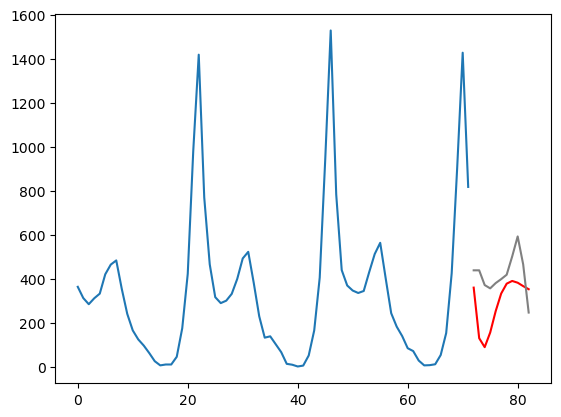

In [210]:
# plot the past 72 hours and the predicted next 6 hours and the real next 6 hours
plt.plot(np.arange(0, 72), test_past_72hr)
plt.plot(np.arange(72, 83), test_pred, color='red', label='predicted')
plt.plot(np.arange(72, 83), ridership_pred_true, color='gray', label='true')

In [224]:
import warnings
warnings.filterwarnings('ignore')

# check the prediction MSE and R2 on the whole dataset
ridership_true = ridership_sample['ridership'].tolist()
ridership_pred_arima = []

for i in range(ridership_sample.shape[0]):
    past_72hr = ridership_sample.iloc[i, :]['last_72hr_ts']
    model = ARIMA(past_72hr, order=(3, 2, 3))
    model_fit = model.fit()
    pred = model_fit.forecast(steps=1).tolist()
    ridership_pred_arima.extend(pred)
    
print('Mean squared error: %.2f' % mean_squared_error(ridership_true, ridership_pred_arima))
print('R2 score: %.2f' % r2_score(ridership_true, ridership_pred_arima))

Mean squared error: 174482.79
R2 score: 0.86


Try 120hr

In [256]:
def last_120hr_ridership(station_complex_id, time_stamp, df):
    try:
        time_stamp = pd.to_datetime(time_stamp)
        df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])
        five_days = pd.Timedelta(days=5)
        five_days_prior = time_stamp - five_days
        df_station = df[df['station_complex_id'] == station_complex_id]
        df_station_5days = df_station[(df_station['transit_timestamp'] >= five_days_prior) & (df_station['transit_timestamp'] < time_stamp)]
        df_station_5days.sort_values('transit_timestamp', ascending=True, inplace=True)
        return df_station_5days['ridership'].values
    except:
        return np.nan

ridership_sample['last_120hr_ts'] = ridership_sample.apply(lambda row: last_120hr_ridership(row['station_complex_id'], row['transit_timestamp'], ridership_total), axis=1)    

In [259]:
ridership_sample.to_csv('data/ridership_sample.csv', index=False)

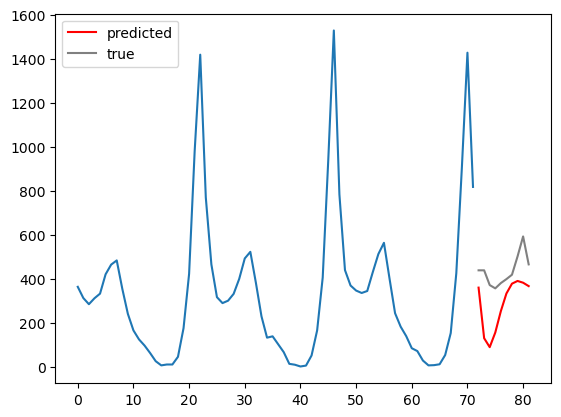

In [263]:
test_past_72hr = ridership_sample.iloc[0, :]['last_72hr_ts']

ridership_pred_true = []
ridership_pred_true.append(ridership_sample.iloc[0, :]['ridership'])
ridership_pred_true.extend(ridership_sample.iloc[0, :]['next_24hr_ts'][:9])

arima_model = ARIMA(test_past_72hr, order=(2, 2, 2))
arima_model_fit = arima_model.fit()
test_pred = arima_model_fit.forecast(steps=10).tolist()

# plot the past 72 hours and the predicted next 6 hours and the real next 6 hours
plt.plot(np.arange(0, 72), test_past_72hr)
plt.plot(np.arange(72, 82), test_pred, color='red', label='predicted')
plt.plot(np.arange(72, 82), ridership_pred_true, color='gray', label='true')

plt.legend()


In [251]:
# choose p, d, q based on AIC
# do a grid search for p, d, q

best_params = []

for p in range(1, 6):
    for q in range(1, 6):
        for d in range(1, 3):
            model = ARIMA(test_past_72hr, order=(p, d, q))
            model_fit = model.fit()
            best_params.append((p, d, q, model_fit.aic))

best_params.sort(key=lambda x: x[3])
best_params

[(2, 2, 2, 954.6273168643767),
 (2, 2, 3, 955.5620870598011),
 (2, 1, 3, 955.9191452842479),
 (1, 2, 4, 956.6773306628039),
 (2, 1, 1, 957.4200926399687),
 (4, 2, 2, 957.4748174857522),
 (1, 2, 5, 958.3827315427001),
 (2, 1, 2, 958.610241014366),
 (3, 2, 5, 958.8252144712444),
 (3, 2, 3, 958.8392407942124),
 (3, 1, 1, 958.8717716474442),
 (1, 1, 2, 958.8923911740344),
 (2, 2, 1, 959.1104647248009),
 (1, 1, 3, 959.3718258788357),
 (3, 2, 4, 960.0921199173101),
 (4, 1, 1, 960.2031718268084),
 (3, 1, 2, 960.4909256593816),
 (3, 2, 1, 960.7071978624878),
 (1, 1, 4, 961.0336327131905),
 (5, 2, 3, 961.3474770101866),
 (5, 1, 3, 961.36144565617),
 (4, 2, 1, 961.6540141178028),
 (3, 1, 5, 961.6698288558073),
 (1, 2, 2, 961.9083959848531),
 (5, 1, 1, 962.0912676562472),
 (3, 1, 3, 962.4823114432173),
 (4, 1, 3, 962.5026490626021),
 (4, 2, 3, 962.5679712273281),
 (1, 1, 5, 962.7976734856098),
 (4, 1, 2, 962.8200704883604),
 (5, 2, 1, 962.9256824306925),
 (3, 2, 2, 962.9271012562085),
 (2, 1, 4, 

In [ ]:
# plot the past 72 hours and the predicted next 6 hours and the real next 6 hours
plt.plot(np.arange(0, 72), test_past_72hr)
plt.plot(np.arange(72, 82), test_pred, color='red', label='predicted')
plt.plot(np.arange(72, 82), ridership_pred_true, color='gray', label='true')
plt.legend()

